<a href="https://colab.research.google.com/github/newgabo/TP2-AA/blob/master/Tp2_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import glob
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa.display import specshow

In [2]:
# bajo y descomprimo archivo
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir speechcommands
!tar -xf speech_commands_v0.01.tar.gz -C /content/speechcommands

--2020-07-01 20:02:52--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.189.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  65.9MB/s    in 22s     

2020-07-01 20:03:14 (64.7 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
# usando glob, armo las listas con los numeros a entrenar
# del 0 al 9
zero_wavs = glob.glob('speechcommands/zero/*.wav')
one_wavs = glob.glob('speechcommands/one/*.wav')
two_wavs = glob.glob('speechcommands/two/*.wav')
three_wavs = glob.glob('speechcommands/three/*.wav')
four_wavs = glob.glob('speechcommands/four/*.wav')
five_wavs = glob.glob('speechcommands/five/*.wav')
six_wavs = glob.glob('speechcommands/six/*.wav')
seven_wavs = glob.glob('speechcommands/seven/*.wav')
eight_wavs = glob.glob('speechcommands/eight/*.wav')
nine_wavs = glob.glob('speechcommands/nine/*.wav')


In [ ]:
zero_wavs[0:5]
#zero_wavs

['speechcommands/zero/b087aa0e_nohash_3.wav',
 'speechcommands/zero/1a892463_nohash_1.wav',
 'speechcommands/zero/fb2f3242_nohash_0.wav',
 'speechcommands/zero/1b755c65_nohash_0.wav',
 'speechcommands/zero/9aa21fa9_nohash_1.wav']

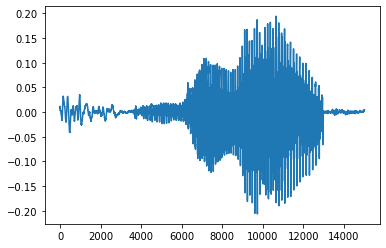

In [ ]:
#abrimos uno de los audios para ver su contenido
# y lo graficamos
x,sr = librosa.core.load(zero_wavs[15],sr=None)
plt.plot(x)

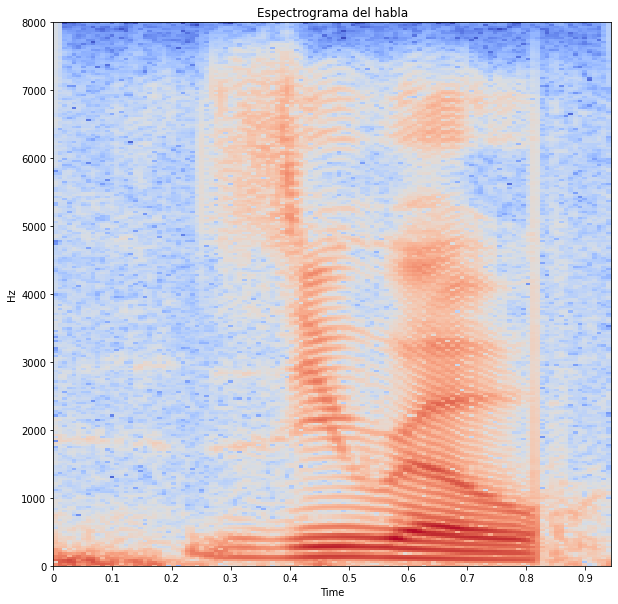

In [ ]:
winsize=512
hopsize=128

# espectograma y reduccion de atributos

spectrogram = librosa.stft(x,n_fft=winsize,hop_length=hopsize,win_length=winsize)
mag_spectrogram = np.abs(spectrogram)

plt.figure(figsize=(10,10))
plt.title('Espectrograma del habla')
specshow(10*np.log10(mag_spectrogram),sr=16000,hop_length=hopsize,y_axis='linear',x_axis='time',vmin=-50)
Audio(x,rate=16000)


In [ ]:
# esta funcion es la que nos va a reducir las dimensiones de los archivos, nos quedan 78 atributos

def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  
  return summary_features, feat_names  

In [ ]:
# ejempplo de calculo de features para un archivo
feat, names = calculate_features(one_wavs[5])

feat

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std
0,-410.960018,90.205405,-43.65955,11.257389,-21.927111,3.092582,-24.447205,-9.314933,-5.254804,-6.348443,-10.306923,0.452411,0.016641,118.673576,27.42981,41.975756,12.033721,24.65313,12.936496,10.254618,11.926985,7.850823,7.111671,5.5057,4.837379,0.02248,-0.842406,-0.031951,0.32876,-0.274609,-0.300629,0.050791,0.080141,-0.421044,-0.500939,-0.108157,0.043026,-0.244845,-0.000018,35.435837,14.225455,18.493169,7.769812,9.926311,8.28876,7.321598,5.952798,4.462509,4.349284,4.47753,4.420265,0.00704,-1.243167,0.231261,0.850628,-0.018813,-0.19661,-0.151115,0.339809,0.188872,-0.048065,-0.025823,0.064293,0.399318,0.000006,20.661824,15.342412,13.223604,8.4503,9.585532,7.397579,8.092718,6.317277,4.431471,5.127934,5.726896,5.181803,0.003843


In [ ]:
import numpy as np
import pickle
import re

# armo un array con las 10 listas para recorrerlo

vec_num=[['zero',zero_wavs],
         ['one',one_wavs],
         ['two',two_wavs], 
         ['three',three_wavs],
         ['four',four_wavs],
         ['five', five_wavs], 
         ['six', six_wavs],
         ['seven',seven_wavs],
         ['eight',eight_wavs],
         ['nine',nine_wavs]]


In [ ]:
df_all=pd.DataFrame()

for numero in vec_num:
  
  print(numero[0])

  for arch in numero[1]:
    
    # calculo los features del archivo
    feat, names = calculate_features(arch)

    # armo dataframe con los features y los nombres de columnas
    df=pd.DataFrame(feat,index=names).transpose()

    # busco la posicion del primer /
    pos=arch.find('/')

    # agrego los atributos que faltan
    df['target']= numero[0]
    df['file'] = arch[pos+1:]
    df['group']= 'train'
 
    # busco si esta en validation list
    with open('speechcommands/validation_list.txt','r') as f:
      texto = f.read()
 
    matches = re.findall(arch[pos+1:], texto)
    if (len(matches) >0):
      df['group']='validation'

    # busco si esta en testing list
    with open('speechcommands/testing_list.txt','r') as f:
      texto = f.read()
 
    matches = re.findall(arch[pos+1:], texto)
    if (len(matches) >0):
      df['group']='testing'
    
    # concateno los dataframe para armar el dataframe final
    df_all=pd.concat([df_all,df])

  print(numero[0])

# resultado
df_all.head()


zero
zero
one
one
two
two
three
three
four
four
five
five
six
six
seven
seven
eight
eight
nine
nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file,group
0,-447.013484,82.107158,30.128931,37.495112,26.410458,19.349560,0.220880,13.787186,-2.090889,10.186531,-7.550286,10.405959,0.019915,105.243203,66.167088,31.379087,17.044830,16.423239,8.988007,9.500313,9.899634,9.093648,6.358469,9.571304,5.839290,0.020091,2.496440,2.679139,1.382694,0.637334,0.352528,-0.074789,-0.395724,0.065883,0.209853,0.001462,-0.285006,-0.134541,0.000150,30.677672,...,16.546769,10.995023,9.365660,8.321029,6.260240,6.316014,6.087133,5.224652,6.299041,4.700034,0.005500,-0.892144,-0.598645,-0.007513,0.030784,0.059811,0.011742,-0.035612,-0.153660,0.043779,0.055412,-0.318548,-0.205389,0.000004,27.638152,17.219400,17.457224,12.668412,12.201276,9.884946,6.972104,6.423280,8.005895,6.840991,7.951120,6.086549,0.004210,zero,zero/b087aa0e_nohash_3.wav,0
0,-467.465407,106.485956,-15.164009,-15.916635,-14.513851,-0.943692,-22.114575,-2.098791,-15.078180,-5.339973,-2.508492,-4.010259,0.013808,143.690633,70.235703,41.396458,40.314901,12.078412,11.622522,22.692563,9.660152,21.297017,13.316683,17.371868,9.550928,0.015601,-7.601924,0.236934,0.089262,-2.493223,-0.741256,-1.250152,-0.836076,-0.696116,0.169622,0.121786,0.354079,-0.369492,-0.000327,39.752012,...,20.762736,13.504974,7.302112,7.357263,9.344045,5.285964,8.008044,7.523747,8.351461,6.590797,0.004400,1.047351,0.668475,0.700569,0.555578,0.056259,0.025067,-0.052724,0.376561,0.467289,-0.150500,-0.275497,-0.094380,0.000007,26.816543,19.741062,18.224348,13.530634,8.566786,8.785448,10.018413,5.969772,7.914729,9.536014,8.486372,7.918756,0.002291,zero,zero/1a892463_nohash_1.wav,0
0,-387.342123,103.399141,19.127111,14.150534,4.236167,2.916593,-8.341188,-4.871776,0.061372,-0.830761,-3.717342,2.287600,0.012329,64.780687,35.179736,33.911680,21.783957,12.907511,6.429770,16.483586,13.218573,10.295328,8.537958,6.550306,5.131923,0.007889,-0.205598,0.652267,-0.219559,0.447939,-0.305171,-0.062667,-0.035065,-0.005668,-0.274419,-0.224229,-0.301606,-0.081482,-0.000002,22.896360,...,13.689751,14.482363,9.326665,5.371619,8.143473,6.305598,7.962056,4.619381,3.983173,4.335403,0.002344,-0.037434,-0.070952,0.116700,-0.117510,-0.021160,0.002680,-0.007003,0.065581,0.036829,0.015601,-0.082768,-0.234645,0.000015,21.679999,12.490425,10.516682,13.017614,10.620068,6.833076,9.695476,7.443200,8.834083,4.591547,4.575489,5.140761,0.001743,zero,zero/fb2f3242_nohash_0.wav,0
0,-375.771001,88.581974,13.049535,1.651397,-6.120394,-24.425935,-23.058834,2.741953,-18.899946,-11.797087,-15.912601,-8.570277,0.052888,138.708791,73.601139,54.730045,47.847029,30.370606,26.227499,24.451802,15.419968,17.421797,7.738904,12.553614,8.558579,0.054276,-0.542655,-0.525245,-0.268917,-0.304237,-0.272000,0.004569,0.134090,0.112030,0.197659,0.364510,0.350942,0.093777,-0.000041,38.240585,...,23.582709,22.242205,18.173672,13.108722,14.280890,8.079822,9.138097,6.514218,6.834413,6.724723,0.017709,-1.362816,-0.248011,-0.293828,0.276406,0.126108,0.236475,0.530542,-0.178179,0.480537,-0.023856,0.242600,-0.027856,-0.000208,24.424516,22.520927,20.459336,19.650590,

In [ ]:
print(df_all.shape)
df_all= df_all.reset_index(drop=True)
df_all.tail()


(23666, 81)


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file,group
23661,-425.321260,77.298699,-12.465525,22.758809,1.052688,6.423097,0.393421,15.342497,-10.500576,13.187967,-7.826215,2.820511,0.011713,141.087661,17.567109,28.326895,15.632098,13.246745,13.592107,14.867421,8.765493,14.178812,11.764592,14.019442,5.077383,0.014064,2.493700,0.390823,-1.278725,0.534158,0.103681,-0.747239,-0.111069,0.582818,-0.221808,-0.317000,-0.153832,0.003908,0.000032,39.806759,...,12.074516,11.332297,9.851395,6.821586,9.616786,6.832101,8.164703,7.177233,6.145546,3.538411,0.004203,-0.442903,-0.267357,-0.247079,0.108780,-0.361898,-0.142895,-0.203172,0.249699,0.210607,0.035836,-0.093903,0.147069,-5.276064e-05,30.047267,16.409861,10.239637,12.902109,11.269292,8.684860,10.215536,9.092610,9.391151,7.552718,6.042507,4.389940,0.002112,nine,nine/b43c8f2f_nohash_0.wav,0
23662,-141.773903,44.288318,-38.525582,33.663262,-1.069285,12.891618,-0.090533,9.355769,-7.508035,18.935799,-6.431086,3.073065,0.134695,116.809061,33.989070,26.737993,29.096483,18.591489,14.909155,10.830120,11.478165,13.308369,7.085704,7.486320,9.861171,0.148864,1.961573,0.740677,-1.104439,-0.779622,0.411608,-0.074032,-0.843982,-0.542015,0.326929,0.648109,0.007821,-0.398254,0.000195,31.795633,...,9.827363,10.335547,8.169447,7.962607,6.722466,5.637681,7.277374,4.575510,5.588915,5.328817,0.039388,0.527764,-0.044817,-0.417031,-0.163118,0.114390,-0.058332,-0.165313,-0.201592,0.078767,0.185721,0.230525,0.371264,-2.055939e-04,27.807114,13.687931,10.091836,8.870814,7.431951,8.995196,7.376599,6.042073,6.155534,5.186543,6.191338,5.463594,0.017145,nine,nine/0ac15fe9_nohash_0.wav,0
23663,-452.933438,82.830889,-53.546334,1.779379,-20.244043,-1.732219,-4.843998,-7.995251,-1.225572,-20.657038,-19.469285,-3.512496,0.032800,179.057086,44.208100,55.283765,20.715946,20.374076,14.054486,18.714023,26.853700,13.606366,18.821797,14.865196,11.340855,0.037211,5.898321,3.623510,-0.760064,-0.357661,-0.199259,-0.371875,1.277952,1.832641,-0.326182,-0.379028,-0.420103,-0.797491,0.000099,57.869474,...,20.376902,13.361405,11.849961,9.741755,9.247170,9.680044,8.548130,10.084674,7.125559,7.163459,0.010303,1.357571,0.659591,-0.058994,0.204506,0.231688,-0.042049,-0.145186,0.086630,-0.032258,0.261633,0.063121,-0.044279,2.138150e-06,45.951505,23.255172,15.616910,17.443526,13.973349,12.024264,11.285789,10.818549,9.136735,9.312034,6.956246,8.185847,0.005867,nine,nine/3b7f817e_nohash_0.wav,0
23664,-367.411368,79.980524,-9.273606,33.749909,-8.914859,-10.692660,-2.128609,-20.097839,9.469424,-11.619382,-2.630504,-7.887587,0.052187,236.251012,53.674086,47.684538,31.536558,24.545004,19.258996,19.555980,15.393452,16.894780,16.090734,7.548928,5.557155,0.052410,-3.122661,-4.132821,-3.055973,-1.677982,-0.365849,0.519564,1.030619,0.953710,0.680608,0.396553,0.206053,0.083566,-0.001333,59.370125,...,19.222504,18.037295,11.184823,14.006801,10.242019,10.720824,9.652374,7.616160,5.495989,5.127673,0.011330,-3.815039,-0.275633,0.898008,-1.227242,-0.124157,1.681510,-0.093976,-0.412987,0.344259,0.169160,-0.238051,0.521346,-2.775091e-0

In [ ]:
# debe coincidir la suma de los largos de las listas con las filas del dataframe final
# son 81 atributos: 78 de los wavs + target + file + group
suma_total=len(zero_wavs)+len(one_wavs)+len(two_wavs)+len(three_wavs)+len(four_wavs)+len(five_wavs)+len(six_wavs)+len(seven_wavs)+len(eigth_wavs)+len(nine_wavs)

print(suma_total)
print(df_all.shape)


23666
(23666, 81)


In [ ]:
# grabo archivo pickle
pickle.dump( df_all, open( "feat_numbers.p", "wb" ) )

In [ ]:
# pruebo levantar el archivo
df_feat = pickle.load( open( "feat_numbers.p", "rb" ) )
print(df_feat.shape)
df_feat.head(10)


(23666, 81)


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file,group
0,-447.013484,82.107158,30.128931,37.495112,26.410458,19.349560,0.220880,13.787186,-2.090889,10.186531,-7.550286,10.405959,0.019915,105.243203,66.167088,31.379087,17.044830,16.423239,8.988007,9.500313,9.899634,9.093648,6.358469,9.571304,5.839290,0.020091,2.496440,2.679139,1.382694,0.637334,0.352528,-0.074789,-0.395724,0.065883,0.209853,0.001462,-0.285006,-0.134541,1.501613e-04,30.677672,...,16.546769,10.995023,9.365660,8.321029,6.260240,6.316014,6.087133,5.224652,6.299041,4.700034,0.005500,-0.892144,-0.598645,-0.007513,0.030784,0.059811,0.011742,-0.035612,-0.153660,0.043779,0.055412,-0.318548,-0.205389,3.535345e-06,27.638152,17.219400,17.457224,12.668412,12.201276,9.884946,6.972104,6.423280,8.005895,6.840991,7.951120,6.086549,0.004210,zero,zero/b087aa0e_nohash_3.wav,0
1,-467.465407,106.485956,-15.164009,-15.916635,-14.513851,-0.943692,-22.114575,-2.098791,-15.078180,-5.339973,-2.508492,-4.010259,0.013808,143.690633,70.235703,41.396458,40.314901,12.078412,11.622522,22.692563,9.660152,21.297017,13.316683,17.371868,9.550928,0.015601,-7.601924,0.236934,0.089262,-2.493223,-0.741256,-1.250152,-0.836076,-0.696116,0.169622,0.121786,0.354079,-0.369492,-3.266844e-04,39.752012,...,20.762736,13.504974,7.302112,7.357263,9.344045,5.285964,8.008044,7.523747,8.351461,6.590797,0.004400,1.047351,0.668475,0.700569,0.555578,0.056259,0.025067,-0.052724,0.376561,0.467289,-0.150500,-0.275497,-0.094380,7.189664e-06,26.816543,19.741062,18.224348,13.530634,8.566786,8.785448,10.018413,5.969772,7.914729,9.536014,8.486372,7.918756,0.002291,zero,zero/1a892463_nohash_1.wav,0
2,-387.342123,103.399141,19.127111,14.150534,4.236167,2.916593,-8.341188,-4.871776,0.061372,-0.830761,-3.717342,2.287600,0.012329,64.780687,35.179736,33.911680,21.783957,12.907511,6.429770,16.483586,13.218573,10.295328,8.537958,6.550306,5.131923,0.007889,-0.205598,0.652267,-0.219559,0.447939,-0.305171,-0.062667,-0.035065,-0.005668,-0.274419,-0.224229,-0.301606,-0.081482,-2.125353e-06,22.896360,...,13.689751,14.482363,9.326665,5.371619,8.143473,6.305598,7.962056,4.619381,3.983173,4.335403,0.002344,-0.037434,-0.070952,0.116700,-0.117510,-0.021160,0.002680,-0.007003,0.065581,0.036829,0.015601,-0.082768,-0.234645,1.477635e-05,21.679999,12.490425,10.516682,13.017614,10.620068,6.833076,9.695476,7.443200,8.834083,4.591547,4.575489,5.140761,0.001743,zero,zero/fb2f3242_nohash_0.wav,0
3,-375.771001,88.581974,13.049535,1.651397,-6.120394,-24.425935,-23.058834,2.741953,-18.899946,-11.797087,-15.912601,-8.570277,0.052888,138.708791,73.601139,54.730045,47.847029,30.370606,26.227499,24.451802,15.419968,17.421797,7.738904,12.553614,8.558579,0.054276,-0.542655,-0.525245,-0.268917,-0.304237,-0.272000,0.004569,0.134090,0.112030,0.197659,0.364510,0.350942,0.093777,-4.095826e-05,38.240585,...,23.582709,22.242205,18.173672,13.108722,14.280890,8.079822,9.138097,6.514218,6.834413,6.724723,0.017709,-1.362816,-0.248011,-0.293828,0.276406,0.126108,0.236475,0.530542,-0.178179,0.480537,-0.023856,0.242600,-0.027856,-2.079558e-04,24.42451

In [33]:
#levanto el archivo pickle desde github
from io import BytesIO

import pickle
import requests
import pandas as pd

github_Link_ = 'https://github.com/newgabo/TP2-AA/blob/master/feat_numbers.p?raw=true'
file_ = BytesIO(requests.get(github_Link_).content)
df_features = pickle.load(file_)

# separo los archivos de validacion
list_val=df_features[df_features.group=='validation'].file

In [45]:
list_val

11       zero/060cd039_nohash_0.wav
16       zero/b7a6f709_nohash_1.wav
31       zero/dca2797e_nohash_3.wav
34       zero/f5e5e8b0_nohash_1.wav
35       zero/439c84f4_nohash_4.wav
                    ...            
23582    nine/541120c7_nohash_1.wav
23599    nine/2ce7534c_nohash_1.wav
23608    nine/dbaf8fc6_nohash_0.wav
23642    nine/6a27a9bf_nohash_0.wav
23647    nine/d197e3ae_nohash_0.wav
Name: file, Length: 2494, dtype: object

In [44]:
import shutil
import os

# muevo todos los archivos de la lista a una carpeta nueva que se llama Validation
# conservo las subcarpetas de los numeros, asi coincide con el nombre del 'file' del dataframe

for file_val in list_val:
  pos=file_val.find('/')

  carpeta = file_val[0:pos]
  #creo carpeta si no existe
  os.makedirs('Validation/'+carpeta, exist_ok=True)

  if os.path.exists('speechcommands/'+file_val):
    #muevo los archivos de la lista de validation
    shutil.move('speechcommands/'+file_val, 'Validation/'+file_val)
  


In [46]:
from google.colab import files
# zipeo y descargo archivo

!zip -r /content/validation.zip /content/Validation

from google.colab import files
files.download("/content/validation.zip")

  adding: content/Validation/ (stored 0%)
  adding: content/Validation/eight/ (stored 0%)
  adding: content/Validation/eight/6c0f6493_nohash_2.wav (deflated 51%)
  adding: content/Validation/eight/c4cfbe43_nohash_3.wav (deflated 33%)
  adding: content/Validation/eight/264f471d_nohash_1.wav (deflated 18%)
  adding: content/Validation/eight/750e3e75_nohash_0.wav (deflated 30%)
  adding: content/Validation/eight/9db2bfe9_nohash_0.wav (deflated 56%)
  adding: content/Validation/eight/ab7b5acd_nohash_0.wav (deflated 28%)
  adding: content/Validation/eight/f34e6f44_nohash_0.wav (deflated 31%)
  adding: content/Validation/eight/171b56dc_nohash_0.wav (deflated 40%)
  adding: content/Validation/eight/ad63d93c_nohash_2.wav (deflated 41%)
  adding: content/Validation/eight/66774579_nohash_0.wav (deflated 22%)
  adding: content/Validation/eight/53d5b86f_nohash_1.wav (deflated 34%)
  adding: content/Validation/eight/638685f2_nohash_0.wav (deflated 55%)
  adding: content/Validation/eight/826268f8_no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>